<a href="https://colab.research.google.com/github/manuel-suarez/tensorflow_examples/blob/main/Load_and_preprocess_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Load and preprocess images](https://www.tensorflow.org/tutorials/load_data/images?hl=en)

## [Setup](https://www.tensorflow.org/tutorials/load_data/images?hl=en#setup)

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
print(tf.__version__)

2.8.2


## [Download the flowers dataset](https://www.tensorflow.org/tutorials/load_data/images?hl=en#download_the_flowers_dataset)

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 2s 0us/step


In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


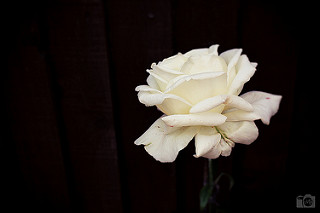

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

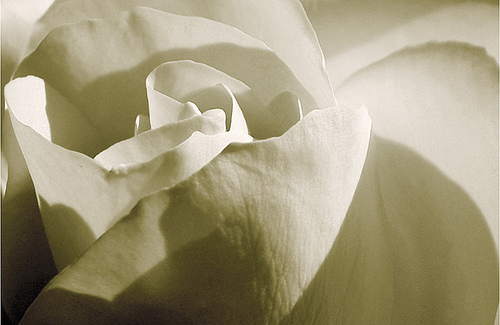

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

## [Load data using a Keras utility](https://www.tensorflow.org/tutorials/load_data/images?hl=en#load_data_using_a_keras_utility)

In [7]:
batch_size = 32
img_height = 180
img_width = 180

In [27]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## [Visualize data](https://www.tensorflow.org/tutorials/load_data/images?hl=en#visualize_the_data)

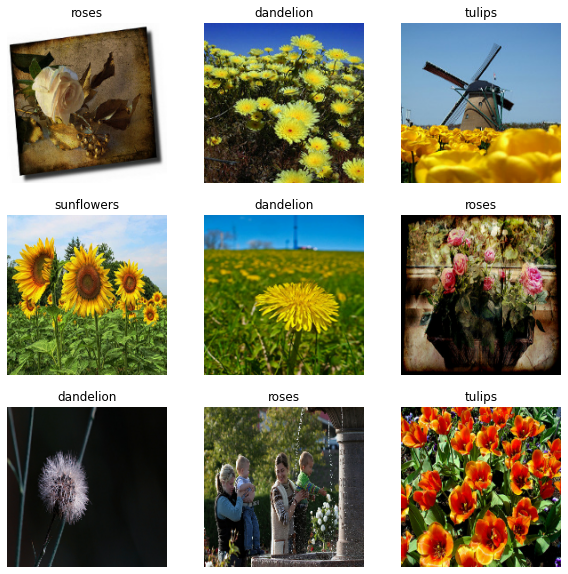

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## [Standardize the data](https://www.tensorflow.org/tutorials/load_data/images?hl=en#standardize_the_data)

In [29]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [30]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## [Train a model](https://www.tensorflow.org/tutorials/load_data/images?hl=en#train_a_model)

In [31]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [32]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [33]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 120s 1s/step - loss: 1.2202 - accuracy: 0.4779 - val_loss: 1.1001 - val_accuracy: 0.5845
Epoch 2/3
92/92 [==============================] - 115s 1s/step - loss: 0.9877 - accuracy: 0.6097 - val_loss: 1.0258 - val_accuracy: 0.6172
Epoch 3/3
92/92 [==============================] - 121s 1s/step - loss: 0.8296 - accuracy: 0.6866 - val_loss: 0.8963 - val_accuracy: 0.6676


## [Using tf.data for finer control](https://www.tensorflow.org/tutorials/load_data/images?hl=en#using_tfdata_for_finer_control)

In [34]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [35]:
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/sunflowers/6495554833_86eb8faa8e_n.jpg'
b'/root/.keras/datasets/flower_photos/tulips/16938892686_3613ea68e8_n.jpg'
b'/root/.keras/datasets/flower_photos/daisy/5884807222_22f5326ba8_m.jpg'
b'/root/.keras/datasets/flower_photos/daisy/1299501272_59d9da5510_n.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/8980164828_04fbf64f79_n.jpg'


### The tree structure of the files can be used to compile a class_names list.

In [36]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


### Split the dataset into training and validation sets:

In [37]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

### You can print the length of each dataset as follows:

In [40]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


In [41]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [42]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [43]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

### Use Dataset.map to create a dataset of image, label pairs:

In [44]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [45]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  4


## [Configure dataset for performance](https://www.tensorflow.org/tutorials/load_data/images?hl=en#configure_dataset_for_performance)

In [46]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

## [Visualize data](https://www.tensorflow.org/tutorials/load_data/images?hl=en#visualize_the_data_2)

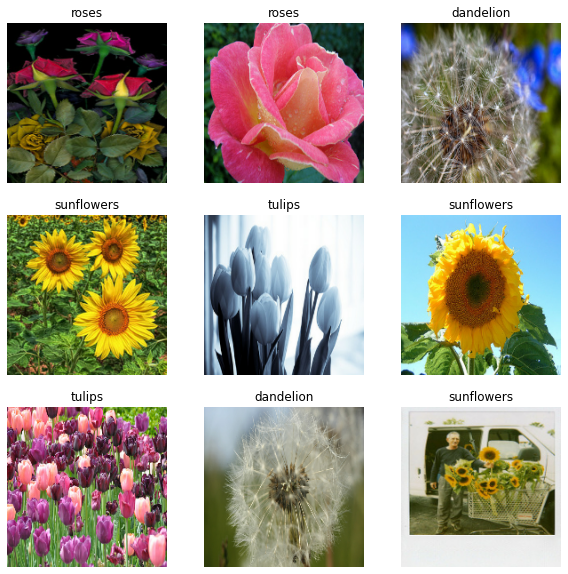

In [47]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

## [Continue training the model](https://www.tensorflow.org/tutorials/load_data/images?hl=en#continue_training_the_model)

In [48]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 139s 1s/step - loss: 0.7320 - accuracy: 0.7193 - val_loss: 0.7304 - val_accuracy: 0.7221
Epoch 2/3
92/92 [==============================] - 119s 1s/step - loss: 0.5203 - accuracy: 0.8048 - val_loss: 0.7547 - val_accuracy: 0.7275
Epoch 3/3
92/92 [==============================] - 121s 1s/step - loss: 0.3390 - accuracy: 0.8825 - val_loss: 0.8922 - val_accuracy: 0.7057
